In [21]:
from os import path
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Định nghĩa đường dẫn
DATA_DIR = r"c:\Users\Admin\Python\ABSA_Prompting\data"
RESULT_DIR = r"c:\Users\Admin\Python\ABSA_Prompting\results"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

In [22]:
# CONFIG - Restaurant dataset

ViABSA_Restaurant_dir = path.join(DATA_DIR, 'ViABSA_Restaurant')
train_file = path.join(ViABSA_Restaurant_dir, 'data_train.csv')
test_file = path.join(ViABSA_Restaurant_dir, 'data_test.csv')

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Columns: {list(train_df.columns)}")
print(f"First few rows:")
print(train_df.head())

Train data shape: (2961, 13)
Test data shape: (500, 13)
Columns: ['Review', 'AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL']
First few rows:
                                              Review  AMBIENCE#GENERAL  \
0  _ Ảnh chụp từ hôm qua, đi chơi với gia đình và...                 0   
1  _Hương vị thơm ngon, ăn cay cay rất thích, nêm...                 1   
2  - 1 bàn tiệc hoành tráng 3 đứa ăn no muốn tắt ...                 2   
3  - Các bạn nhìn cái chảo này có to không 🙄🙄🙄- T...                 0   
4  - Cháo: có nhiều hương cho các bạn chọn, nhưng...                 0   

   DRINKS#PRICES  DRINKS#QUALITY  DRINKS#STYLE&OPTIONS  FOOD#PRICES  \
0              0               0                     0            0   
1              0               0                     0            3   
2       

In [23]:
# SETUP DATA - Restaurant aspects
# Restaurant dataset có format: Review, aspect_columns với giá trị 0,1,2,3
# 0: không có aspect, 1: positive, 2: neutral, 3: negative

aspects = [col for col in train_df.columns if col != 'Review']
print(f"Restaurant aspects: {aspects}")
print(f"Number of aspects: {len(aspects)}")

# Sử dụng train/test datasets có sẵn
train_data = train_df.copy()
test_data = test_df.copy()

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

# Tạo binary labels cho aspect detection
for aspect in aspects:
    train_data[aspect + '_label'] = (train_data[aspect] != 0).astype(int)
    test_data[aspect + '_label'] = (test_data[aspect] != 0).astype(int)

aspect_labels = [aspect + '_label' for aspect in aspects]

X_train = train_data['Review']
y_train_aspect = train_data[aspect_labels]
X_test = test_data['Review']
y_test_aspect = test_data[aspect_labels]

Restaurant aspects: ['AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL']
Number of aspects: 12
Train size: 2961
Test size: 500


In [24]:
# Kiểm tra dữ liệu
print(f"X_train shape: {X_train.shape}")
print(f"y_train_aspect shape: {y_train_aspect.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_aspect shape: {y_test_aspect.shape}")

print("\nSample data:")
print(train_data[['Review'] + aspects[:3]].head())

print("\nAspect distribution in training data:")
for aspect in aspects:
    count = (train_data[aspect] != 0).sum()
    print(f"{aspect}: {count} mentions")

X_train shape: (2961,)
y_train_aspect shape: (2961, 12)
X_test shape: (500,)
y_test_aspect shape: (500, 12)

Sample data:
                                              Review  AMBIENCE#GENERAL  \
0  _ Ảnh chụp từ hôm qua, đi chơi với gia đình và...                 0   
1  _Hương vị thơm ngon, ăn cay cay rất thích, nêm...                 1   
2  - 1 bàn tiệc hoành tráng 3 đứa ăn no muốn tắt ...                 2   
3  - Các bạn nhìn cái chảo này có to không 🙄🙄🙄- T...                 0   
4  - Cháo: có nhiều hương cho các bạn chọn, nhưng...                 0   

   DRINKS#PRICES  DRINKS#QUALITY  
0              0               0  
1              0               0  
2              0               0  
3              0               0  
4              0               0  

Aspect distribution in training data:
AMBIENCE#GENERAL: 737 mentions
DRINKS#PRICES: 102 mentions
DRINKS#QUALITY: 114 mentions
DRINKS#STYLE&OPTIONS: 102 mentions
FOOD#PRICES: 1401 mentions
FOOD#QUALITY: 2658 mentions
FOOD#S

In [25]:
# Pipeline phát hiện khía cạnh (multi-label)
pipeline_aspect = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', MultiOutputClassifier(LogisticRegression(solver='liblinear', max_iter=1000)))
])

# Huấn luyện mô hình
print("Training aspect detection model...")
pipeline_aspect.fit(X_train, y_train_aspect)

# Dự đoán khía cạnh trên test set
print("Predicting aspects...")
y_pred_aspect = pipeline_aspect.predict(X_test)

print("Aspect detection completed!")

Training aspect detection model...
Predicting aspects...
Aspect detection completed!


In [26]:
# Tính F1 score cho aspect detection
f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro') 
print(f"F1_ad (Aspect Detection): {f1_ad:.4f}")

# F1 cho từng aspect
print("\nF1 scores for individual aspects:")
for i, aspect in enumerate(aspects):
    f1_individual = f1_score(y_test_aspect.iloc[:, i], y_pred_aspect[:, i])
    print(f"{aspect}: {f1_individual:.4f}")

F1_ad (Aspect Detection): 0.7092

F1 scores for individual aspects:
AMBIENCE#GENERAL: 0.6458
DRINKS#PRICES: 0.0000
DRINKS#QUALITY: 0.0278
DRINKS#STYLE&OPTIONS: 0.0000
FOOD#PRICES: 0.7994
FOOD#QUALITY: 0.9551
FOOD#STYLE&OPTIONS: 0.9173
LOCATION#GENERAL: 0.1347
RESTAURANT#GENERAL: 0.5765
RESTAURANT#MISCELLANEOUS: 0.0000
RESTAURANT#PRICES: 0.0000
SERVICE#GENERAL: 0.6787



Confusion matrix for aspect 'AMBIENCE#GENERAL':


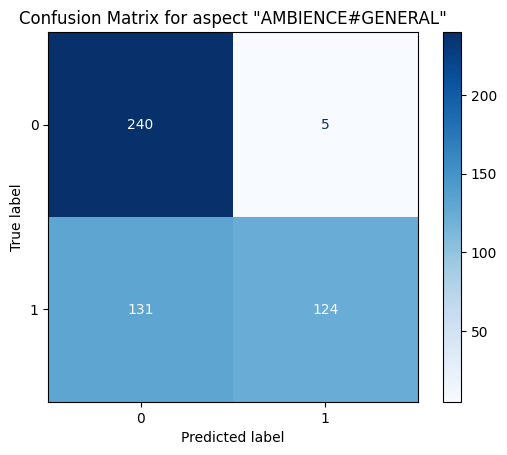

In [27]:
# Confusion matrix cho một khía cạnh ví dụ (chọn aspect đầu tiên)
if len(aspects) > 0:
    aspect = aspects[0]  # Chọn aspect đầu tiên
    idx = aspects.index(aspect)
    print(f"\nConfusion matrix for aspect '{aspect}':")

    cm = confusion_matrix(y_test_aspect[aspect + '_label'], y_pred_aspect[:, idx])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for aspect "{aspect}"')
    plt.show()

In [28]:
# Map nhãn cảm xúc thành số cho Restaurant dataset
# 0=none, 1=positive, 2=neutral, 3=negative
sentiment_map = {0: -1, 1: 2, 2: 1, 3: 0} 

# Chuẩn bị y_train_sentiment và y_test_sentiment
y_train_sentiment = {}
y_test_sentiment = {}

for aspect in aspects:
    y_train_sentiment[aspect] = train_data[aspect].map(sentiment_map).fillna(-1).astype(int)
    y_test_sentiment[aspect] = test_data[aspect].map(sentiment_map).fillna(-1).astype(int)

print("Sentiment mapping completed!")
print("Mapping: 0=none(-1), 1=positive(2), 2=neutral(1), 3=negative(0)")

Sentiment mapping completed!
Mapping: 0=none(-1), 1=positive(2), 2=neutral(1), 3=negative(0)


In [29]:
# Huấn luyện bộ phân loại cảm xúc cho từng khía cạnh
pipeline_sentiment = {}
print("Training sentiment classification models...")

for aspect in aspects:
    # Chọn mẫu có khía cạnh trong tập train
    mask_train = y_train_aspect[aspect + '_label'] == 1
    X_train_aspect = X_train[mask_train]
    y_train_aspect_sent = y_train_sentiment[aspect][mask_train]
    
    if len(X_train_aspect) > 0 and len(y_train_aspect_sent.unique()) > 1:
        pipe = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
            ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=1000)))
        ])
        pipe.fit(X_train_aspect, y_train_aspect_sent)
        pipeline_sentiment[aspect] = pipe
        print(f"  - Trained sentiment classifier for {aspect} ({len(X_train_aspect)} samples)")
    else:
        pipeline_sentiment[aspect] = None
        print(f"  - Skipped {aspect} (insufficient data)")

print("Sentiment classification training completed!")

Training sentiment classification models...
  - Trained sentiment classifier for AMBIENCE#GENERAL (737 samples)
  - Trained sentiment classifier for DRINKS#PRICES (102 samples)
  - Trained sentiment classifier for DRINKS#QUALITY (114 samples)
  - Trained sentiment classifier for DRINKS#STYLE&OPTIONS (102 samples)
  - Trained sentiment classifier for FOOD#PRICES (1401 samples)
  - Trained sentiment classifier for FOOD#QUALITY (2658 samples)
  - Trained sentiment classifier for FOOD#STYLE&OPTIONS (1746 samples)
  - Trained sentiment classifier for LOCATION#GENERAL (373 samples)
  - Trained sentiment classifier for RESTAURANT#GENERAL (855 samples)
  - Trained sentiment classifier for RESTAURANT#MISCELLANEOUS (151 samples)
  - Trained sentiment classifier for RESTAURANT#PRICES (263 samples)
  - Trained sentiment classifier for SERVICE#GENERAL (795 samples)
Sentiment classification training completed!


In [30]:
# Dự đoán cảm xúc cho từng khía cạnh trên test set
print("Predicting sentiments...")
num_samples = len(X_test)
y_pred_sentiment = np.full((num_samples, len(aspects)), -1)  # -1 nghĩa là không dự đoán

for i, aspect in enumerate(aspects):
    pipe = pipeline_sentiment[aspect]
    if pipe is not None:
        mask_pred = y_pred_aspect[:, i] == 1
        if np.any(mask_pred):
            X_test_aspect = X_test[mask_pred]
            y_pred_sentiment[mask_pred, i] = pipe.predict(X_test_aspect)
            print(f"  - Predicted sentiments for {aspect} ({np.sum(mask_pred)} samples)")

print("Sentiment prediction completed!")

Predicting sentiments...
  - Predicted sentiments for AMBIENCE#GENERAL (129 samples)
  - Predicted sentiments for DRINKS#QUALITY (1 samples)
  - Predicted sentiments for FOOD#PRICES (347 samples)
  - Predicted sentiments for FOOD#QUALITY (500 samples)
  - Predicted sentiments for FOOD#STYLE&OPTIONS (456 samples)
  - Predicted sentiments for LOCATION#GENERAL (14 samples)
  - Predicted sentiments for RESTAURANT#GENERAL (169 samples)
  - Predicted sentiments for SERVICE#GENERAL (102 samples)
Sentiment prediction completed!


In [31]:
# Tính F1_sc cho từng khía cạnh và trung bình
f1_sc_list = []
print("\nSentiment Classification F1 scores:")

for i, aspect in enumerate(aspects):
    mask = (y_pred_aspect[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)
        print(f"F1_sc ({aspect}): {f1:.4f}")
    else:
        print(f"F1_sc ({aspect}): No predictions")

f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0
print(f"\nF1_sc (Sentiment Classification, average): {f1_sc:.4f}")


Sentiment Classification F1 scores:
F1_sc (AMBIENCE#GENERAL): 0.7651
F1_sc (DRINKS#PRICES): No predictions
F1_sc (DRINKS#QUALITY): 1.0000
F1_sc (DRINKS#STYLE&OPTIONS): No predictions
F1_sc (FOOD#PRICES): 0.5933
F1_sc (FOOD#QUALITY): 0.8265
F1_sc (FOOD#STYLE&OPTIONS): 0.7493
F1_sc (LOCATION#GENERAL): 0.4872
F1_sc (RESTAURANT#GENERAL): 0.8309
F1_sc (RESTAURANT#MISCELLANEOUS): No predictions
F1_sc (RESTAURANT#PRICES): No predictions
F1_sc (SERVICE#GENERAL): 0.6073

F1_sc (Sentiment Classification, average): 0.7324


FINAL RESULTS - RESTAURANT DATASET
F1_ad (Aspect Detection): 0.7092
F1_sc (Sentiment Classification): 0.7324
Number of aspects: 12
Train samples: 2961
Test samples: 500


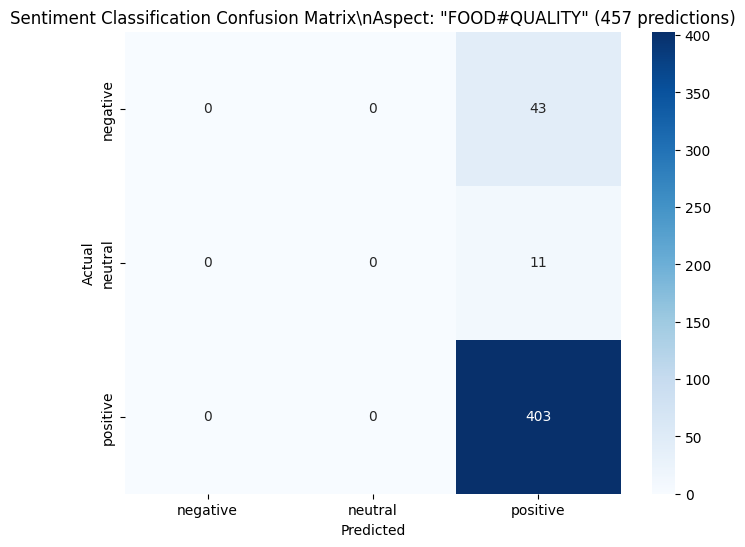

In [32]:
# Kết quả cuối cùng cho Restaurant dataset
print("="*50)
print("FINAL RESULTS - RESTAURANT DATASET")
print("="*50)
print(f"F1_ad (Aspect Detection): {f1_ad:.4f}")
print(f"F1_sc (Sentiment Classification): {f1_sc:.4f}")
print(f"Number of aspects: {len(aspects)}")
print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# Confusion matrix cho sentiment classification (chọn aspect có nhiều dữ liệu nhất)
if f1_sc_list:  # Nếu có ít nhất 1 aspect được huấn luyện
    # Tìm aspect có nhiều prediction nhất
    aspect_counts = []
    for i, aspect in enumerate(aspects):
        mask = (y_pred_aspect[:, i] == 1) & (y_test_sentiment[aspect] != -1)
        aspect_counts.append((aspect, np.sum(mask), i))
    
    aspect_counts.sort(key=lambda x: x[1], reverse=True)
    
    if aspect_counts[0][1] > 0:
        aspect, count, idx = aspect_counts[0]
        mask = (y_pred_aspect[:, idx] == 1) & (y_test_sentiment[aspect] != -1)
        
        if np.sum(mask) > 0:
            cm = confusion_matrix(y_test_sentiment[aspect][mask], y_pred_sentiment[mask, idx])
            
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['negative', 'neutral', 'positive'], 
                       yticklabels=['negative', 'neutral', 'positive'])
            plt.title(f'Sentiment Classification Confusion Matrix\\nAspect: "{aspect}" ({count} predictions)')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()